## This notebook prepairs data for trianing. it loads in a ROSBAG collected and produces an H5 we use to train 
### By: James Barfield
* pip install rospy
* pip install rosbag
* pip install catkin_pkg
* conda install Pillow
* conda install matplotlib
* conda install h5py

In [1]:
import rosbag
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline
import PIL
import os
import glob
import csv
import h5py


Populating the interactive namespace from numpy and matplotlib


In [2]:
Bag_Name = '/home/james/bagfiles/2017-08-29-12-34-32.bag'
Image_output_dir = '/home/james/bagfiles/Ros_images'
bridge = CvBridge()
bag = rosbag.Bag(Bag_Name)
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'sensor_msgs/Image': '060021388200f6f0f447d0fcd9c64743', 'styx_msgs/TrafficLightArray': 'c7bc7e70513c9a0e00aae005e6355eee'}, topics={'/camera/image_raw': TopicTuple(msg_type='sensor_msgs/Image', message_count=3022, connections=1, frequency=10.17212786752455), '/vehicle/traffic_lights': TopicTuple(msg_type='styx_msgs/TrafficLightArray', message_count=15054, connections=1, frequency=386.96411108035795)})

In [3]:
Image_topic = '/camera/image_raw'
Lights_topic ='/vehicle/traffic_lights'

In [4]:
# pull a sample image and plot from the bag
for topic, msg, t in bag.read_messages(Image_topic):
    cv_image_rgb = bridge.imgmsg_to_cv2(msg, desired_encoding="passthrough")
#     cv_image_bgr = cv2.cvtColor(cv_image_rgb, cv2.COLOR_RGB2BGR)
    
    print("Time:", t)
    break

('Time:', rospy.Time[1504024472482303814])


In [5]:
# pull a sample data and plot from the bag
for topic, msg, t in bag.read_messages(Lights_topic):
    print(msg.lights[0].pose.pose)
    
    print("Time:", t)
    break
    
    
bag.close();

position: 
  x: 1172.418
  y: 1186.316
  z: 5.837643
orientation: 
  x: 0.0
  y: 0.0
  z: 0.00061619942315
  w: 0.999999810149
('Time:', rospy.Time[1504024472359509695])


### Lets load the data into memory and write some images for inspection and write an H5 file for the future

In [ ]:
# Lets write some PNGs for inspection
bridge = CvBridge()
bag = rosbag.Bag(Bag_Name)
count = 0

for topic, msg, t in bag.read_messages(Image_topic):
    cv_image_rgb = bridge.imgmsg_to_cv2(msg, desired_encoding="passthrough")
    cv2.imwrite(os.path.join(Image_output_dir, "frame%06i.png" % count), cv2.cvtColor(cv_image_rgb, cv2.COLOR_RGB2BGR))
#     print "Wrote image %i" % count
    count+=1
bag.close();

In [6]:
# lets load all the images into memory to save them in a giant array
bridge = CvBridge()
bag = rosbag.Bag(Bag_Name)
count = 0
IM_Shape = cv_image_rgb.shape

# Pre-allocate memory to fill
row_count = bag.get_message_count(Image_topic)
Images_RGB = np.empty((row_count,IM_Shape[0], IM_Shape[1], IM_Shape[2]),dtype=np.uint8)
ARR = np.arange(row_count)
Images_index = np.empty(row_count,dtype=np.uint16)

for topic, msg, t in bag.read_messages(Image_topic):
    cv_image_rgb = bridge.imgmsg_to_cv2(msg, desired_encoding="passthrough")
    Images_RGB[count,:,:,:]  = cv_image_rgb
    Images_index[count] = count

    count+=1
bag.close();

## I then hand sorted the images and provided classes for each of the images

In [7]:
# Load the image classes into memory
# Red_light:0 Yellow_light:1 Green_light:2 Dontuse: 3 no_light: 4
c = 0
row_count = bag.get_message_count(Image_topic)
image_class = np.empty(row_count+1)

with open('/home/james/bagfiles/image_classes.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        image_class[c] =int(row[1])
        c+=1


0.0


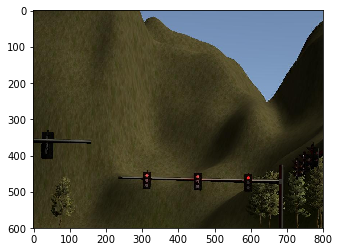

In [8]:
# View so random images or data
ind =np.random.randint(0,row_count)
ind =875
print(image_class[ind])
plt.imshow(Images_RGB[ind])

In [ ]:
h5f = h5py.File('/home/james/bagfiles/Track_Images.h5', 'w')
data_entry = h5f.create_group('Training_Data')
data_entry.create_dataset('Images_RGB', data=Images_RGB)
data_entry.create_dataset('image_class', data=image_class)
h5f.close()